In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from pathlib import Path
from copy import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
from torchvision import models
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
IAM_ROOT = '/home/tobias/datasets/IAM/'

In [9]:
from data import IAMDataset

ds = IAMDataset(
    IAM_ROOT,
    "word",
    "train",
    use_cache=False,
    skip_bad_segmentation=False,
    return_writer_id=True,  # necessary for creating a task dataset based on writer id
)

In [87]:
ds.data

,img_path,img_id,target_enc,writer_id,target
0,/home/tobias/datasets/IAM/words/a03/a03-017/a03-017-04-04.png,a03-017,"[44, 35]",44,of
1,/home/tobias/datasets/IAM/words/a03/a03-017/a03-017-05-02.png,a03-017,"[40, 34, 45, 49]",44,kept
2,/home/tobias/datasets/IAM/words/a03/a03-017/a03-017-07-02.png,a03-017,"[45, 47, 44, 11, 32, 44, 42, 42, 50, 43, 38, 48, 49]",44,pro-communist
3,/home/tobias/datasets/IAM/words/a03/a03-017/a03-017-06-06.png,a03-017,"[44, 35]",44,of
4,/home/tobias/datasets/IAM/words/a03/a03-017/a03-017-02-06.png,a03-017,"[48, 49, 38, 41, 41]",44,still
...,...,...,...,...,...
115313,/home/tobias/datasets/IAM/words/d06/d06-025/d06-025-07-03.png,d06-025,"[52, 44, 47, 41, 33]",205,world
115314,/home/tobias/datasets/IAM/words/d06/d06-025/d06-025-07-06.png,d06-025,"[37, 30, 43, 33]",205,hand
115315,/home/tobias/datasets/IAM/words/d06/d06-025/d06-025-05-03.png,d06-025,"[37, 30, 43, 33]",205,hand
115316,/home/tobias/datasets/IAM/words/d06/d06-025/d06-025-01-01.png,d06-025,"[52, 30, 48]",205,was


In [88]:
print(f"Number of unique writers: {len(ds.data['writer_id'].unique())}")

Number of unique writers: 657


In [5]:
def imshow(im):
    plt.imshow(im, cmap='gray')
    plt.axis('off')

### Distribution of writers

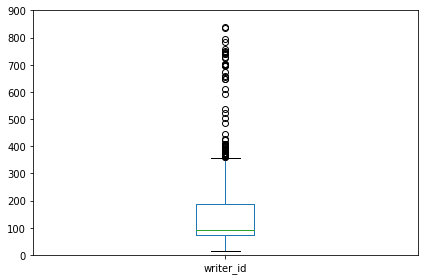

count     657.000000
mean      175.522070
std       223.373375
min        13.000000
25%        73.000000
50%        93.000000
75%       187.000000
max      4222.000000
Name: writer_id, dtype: float64

In [91]:
ds.data["writer_id"].value_counts().plot.box()
plt.ylim(0, 900)
plt.tight_layout()
plt.show()

ds.data["writer_id"].value_counts().describe()

In [90]:
ds.data["writer_id"].value_counts()

0      4222
551     840
588     835
552     793
671     785
       ... 
149      43
99       42
669      30
633      30
611      13
Name: writer_id, Length: 657, dtype: int64

### Show writer with least amount of samples

In [93]:
import pandas as pd

pd.set_option('display.max_colwidth', None)  # show full column values
ds.data[ds.data["writer_id"] == 611].sort_values(by="img_path")[["img_path", "target"]]

,img_path,target
9318,/home/tobias/datasets/IAM/words/p02/p02-155/p02-155-00-00.png,""""
9315,/home/tobias/datasets/IAM/words/p02/p02-155/p02-155-00-01.png,I
9325,/home/tobias/datasets/IAM/words/p02/p02-155/p02-155-00-02.png,made
9327,/home/tobias/datasets/IAM/words/p02/p02-155/p02-155-00-03.png,it
9320,/home/tobias/datasets/IAM/words/p02/p02-155/p02-155-00-04.png,myself
9326,/home/tobias/datasets/IAM/words/p02/p02-155/p02-155-00-05.png,","
9321,/home/tobias/datasets/IAM/words/p02/p02-155/p02-155-00-06.png,""""
9319,/home/tobias/datasets/IAM/words/p02/p02-155/p02-155-00-07.png,Gay
9323,/home/tobias/datasets/IAM/words/p02/p02-155/p02-155-00-08.png,tried
9317,/home/tobias/datasets/IAM/words/p02/p02-155/p02-155-00-09.png,to


## learn2learn

In [94]:
import learn2learn as l2l

dataset = l2l.data.MetaDataset(ds)  # any Pytorch dataset

### Show taskset functionality

In [22]:
transforms_ = [  # learn2learn transforms
    l2l.data.transforms.NWays(dataset, n=2),  # Nways picks N random labels (writers in this case)
    l2l.data.transforms.KShots(dataset, k=shots*2),  # Keeps K samples for each present label.
    l2l.data.transforms.LoadData(dataset),
#     l2l.data.transforms.RemapLabels(dataset),  # Given samples from K classes, maps the labels to 0, ..., K.
#     l2l.data.transforms.ConsecutiveLabels(dataset),  # Re-orders the samples in the task description such that they are sorted in consecutive order.
]

In [23]:
transforms_[1](transforms_[0](None))

SUPPORT SET
Target: have<EOS><PAD><PAD><PAD><PAD><PAD>


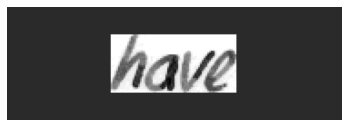

Target: .<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>


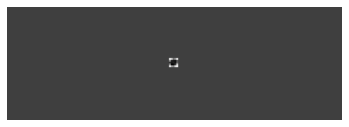

Target: companies<EOS>


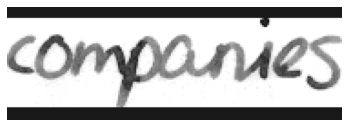

Target: .<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>


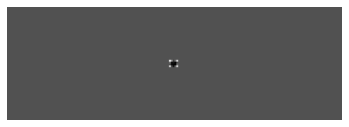

Target: this<EOS><PAD><PAD><PAD><PAD><PAD>


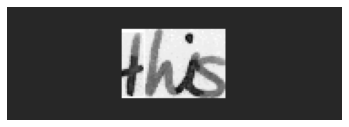

QUERY SET
Target: mortgage<EOS><PAD>


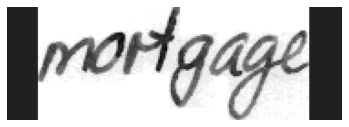

Target: are<EOS><PAD><PAD><PAD><PAD><PAD><PAD>


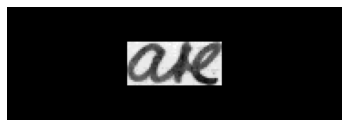

Target: smoking<EOS><PAD><PAD>


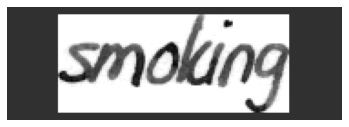

Target: that<EOS><PAD><PAD><PAD><PAD><PAD>


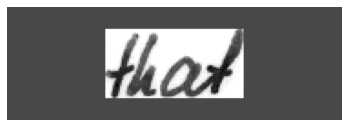

Target: ,<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>


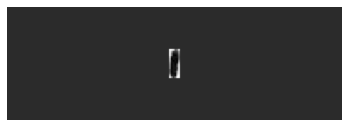

In [188]:
from functools import partial

eos_tkn_idx, sos_tkn_idx, pad_tkn_idx = ds.label_enc.transform(
    [ds._eos_token, ds._sos_token, ds._pad_token]
).tolist()

collate_fn = partial(
    IAMDataset.collate_fn, pad_val=pad_tkn_idx, eos_tkn_idx=eos_tkn_idx, dataset_returns_writer_id=True
)

num_tasks = 3
ways = 1
shots = 5

transforms = [  # learn2learn transforms
    l2l.data.transforms.NWays(dataset, n=ways),  # Nways picks N random labels (writers in this case)
    l2l.data.transforms.KShots(dataset, k=shots*2),  # Keeps K samples for each present label.
    l2l.data.transforms.LoadData(dataset),
#     l2l.data.transforms.RemapLabels(dataset),  # Given samples from K classes, maps the labels to 0, ..., K.
#     l2l.data.transforms.ConsecutiveLabels(dataset),  # Re-orders the samples in the task description such that they are sorted in consecutive order.
]
taskset = l2l.data.TaskDataset(dataset, transforms, num_tasks=num_tasks, task_collate=collate_fn)

model = torch.nn.Identity()

device = "cpu"

for i in range(num_tasks):
    imgs, target, writer_ids = taskset.sample()
    imgs, target = imgs.to(device), target.to(device)

    # Meta-train on the task
    
    # Separate data into support/query set.
    support_indices = np.zeros(imgs.size(0), dtype=bool)
    support_indices[np.arange(ways*shots) * 2] = True  # select even indices for support set
    query_indices = torch.from_numpy(~support_indices)
    support_indices = torch.from_numpy(support_indices)
    support_imgs, support_tgts = imgs[support_indices], target[support_indices]
    query_imgs, query_tgts = imgs[query_indices], target[query_indices]
    
    print("SUPPORT SET")
    for img, tgt in zip(support_imgs, support_tgts):
        imshow(img)
        print(f"Target: {''.join(ds.label_enc.inverse_transform(tgt))}")
#         print(f"Writer: {writer_ids[i].item()}")
        plt.show()
    
    print("QUERY SET")
    for img, tgt in zip(query_imgs, query_tgts):
        imshow(img)
        print(f"Target: {''.join(ds.label_enc.inverse_transform(tgt))}")
#         print(f"Writer: {writer_ids[i].item()}")
        plt.show()

In [127]:
ds_iter = iter(taskset)

In [156]:
x = next(ds_iter)

for img, tgt, writer_id in zip(*x): 
    print("".join(ds.label_enc.inverse_transform(tgt)), writer_id.item())

the<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD> 416
in<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD> 614
representative<EOS> 560
londoners<EOS><PAD><PAD><PAD><PAD><PAD> 295
over<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD> 206


### MAML Test

In [6]:
import pickle
import random
from copy import copy
from pathlib import Path
from functools import partial

from models import *
from lit_models import LitFullPageHTREncoderDecoder, MetaHTR
from lit_callbacks import LogModelPredictionsMAML
from data import IAMDataset

import pytorch_lightning as pl
import pandas as pd
from torch.utils.data import DataLoader, Subset
from pytorch_lightning import seed_everything
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.plugins import DDPPlugin

import learn2learn as l2l

In [7]:
IAM_ROOT = '/home/tobias/datasets/IAM/'
trained_model_path = "/home/tobias/Dropbox/master_AI/HTSM_Honours/masterwork/full-page-handwriting-recognition/lightning_logs/FPHTR_word_smaller_2/checkpoints/epoch=127-char_error_rate=0.1733-word_error_rate=0.1972.ckpt"

encoder = "resnet18"
accumulate_grad_batches = 1
d_model = 24
num_layers = 2
nhead = 2
dim_feedforward = 64
drop_enc = 0.5
drop_dec = 0.5
shots = 2
ways = 2
inner_lr = 0.0001
outer_lr = 0.0001

max_iterations=10
meta_batch_size=2
num_workers=0
num_nodes=1
precision=32
label_smoothing=0.0
limit_train_batches=1.0
early_stopping_patience=5
num_sanity_val_steps=2
save_all_checkpoints=False
val_check_interval=5

data_dir=IAM_ROOT
data_format="word"
use_aachen_splits=True
use_gpu=False
debug_mode=False
seed=1337
validate=False

In [21]:
LOGGING_DIR = "lightning_logs/"

# seed_everything(seed)

# assert Path(trained_model_path).is_file(), \
#         f"{trained_model_path} does not point to a file."

# Load the label encoder for the trained model.
label_enc = None
le_path = Path(trained_model_path).parent.parent / "label_encoder.pkl"
assert le_path.is_file(), (
    f"Label encoder file not found at {le_path}. "
    f"Make sure 'label_encoder.pkl' exists in the lightning_logs directory."
)
label_enc = pd.read_pickle(le_path)

ds = IAMDataset(
    data_dir, "word", "train", use_cache=False, label_enc=label_enc,
    skip_bad_segmentation=True, return_writer_id=True
)

eos_tkn_idx, sos_tkn_idx, pad_tkn_idx = ds.label_enc.transform(
    [ds._eos_token, ds._sos_token, ds._pad_token]
).tolist()
collate_fn = partial(
    IAMDataset.collate_fn, pad_val=pad_tkn_idx, eos_tkn_idx=eos_tkn_idx, dataset_returns_writer_id=True
)

# Split the dataset into train/val/(test).
if use_aachen_splits:
    # Use the Aachen splits for the IAM dataset. It should be noted that these
    # splits do not encompass the complete IAM dataset.
    aachen_path = Path().cwd().parent / "aachen_splits"
    train_splits = (aachen_path / "train.uttlist").read_text().splitlines()
    validation_splits = (
        (aachen_path / "validation.uttlist").read_text().splitlines()
    )
    test_splits = (aachen_path / "test.uttlist").read_text().splitlines()

    data_train = ds.data[ds.data["img_id"].isin(train_splits)]
    data_val = ds.data[ds.data["img_id"].isin(validation_splits)]
    data_test = ds.data[ds.data["img_id"].isin(test_splits)]

    ds_train = copy(ds)
    ds_train.data = data_train
    ds_train.set_transforms_for_split("train")

    ds_val = copy(ds)
    ds_val.data = data_val
    ds_val.set_transforms_for_split("val")

    ds_test = copy(ds)
    ds_test.data = data_test
    ds_test.set_transforms_for_split("test")
else:
    ds_train, ds_val = torch.utils.data.random_split(
        ds, [math.ceil(0.8 * len(ds)), math.floor(0.2 * len(ds))]
    )
    ds_val.dataset = copy(ds)
    ds_val.dataset.set_transforms_for_split("val")

In [7]:
from lit_util import TaskDataloader

ds_meta_train = l2l.data.MetaDataset(ds_train)
ds_meta_val = l2l.data.MetaDataset(ds_val)

# Define learn2learn task transforms
train_tsk_trnsf = [
    # Nways picks N random labels (writers in this case)
    l2l.data.transforms.NWays(ds_meta_train, n=ways),
    # Keeps K samples for each present label.
    l2l.data.transforms.KShots(ds_meta_train, k=shots * 2),
    # Load the data.
    l2l.data.transforms.LoadData(ds_meta_train),
    # Given samples from K classes, maps the labels to 0, ..., K.
    # l2l.data.transforms.RemapLabels(ds_meta_train),
    # Re-orders the samples in the task description such that they are sorted in
    # consecutive order.
    # l2l.data.transforms.ConsecutiveLabels(ds_meta_train),
]
val_tsk_trnsf = [  # learn2learn transforms
    l2l.data.transforms.NWays(ds_meta_val, n=ways),
    l2l.data.transforms.KShots(ds_meta_val, k=shots * 2),
    l2l.data.transforms.LoadData(ds_meta_val),
]
taskset_train = l2l.data.TaskDataset(
    ds_meta_train, train_tsk_trnsf, num_tasks=max_iterations,
    task_collate=collate_fn
)
taskset_val = l2l.data.TaskDataset(
    ds_meta_val, val_tsk_trnsf, num_tasks=2,
    task_collate=collate_fn
)

# datamodule = TaskDataloader(taskset, meta_batch_size)

In [10]:
import shutil
from lit_models import LitFullPageHTREncoderDecoder

# Copy hyper parameters. The loaded model has an associated `hparams.yaml` file,
# which we copy to the current logging directory so that we can load the model
# later using the saved hyper parameters.
# tb_logger = pl_loggers.TensorBoardLogger("lightning_logs/", name="")
model_hparams_file = Path(trained_model_path).parent.parent / "hparams.yaml"
# save_dir = Path(tb_logger.log_dir)
# save_dir.mkdir(exist_ok=True, parents=True)
# shutil.copy(model_hparams_file, save_dir / "hparams.yaml")

# Load the model. Note that the vocab length and special tokens given below
# are derived from the saved label encoder associated with the checkpoint.
model = LitFullPageHTREncoderDecoder.load_from_checkpoint(
    trained_model_path,
    hparams_file=str(model_hparams_file),
    label_encoder=ds.label_enc,
)

In [20]:
list(model.modules())

[LitFullPageHTREncoderDecoder(
   (model): FullPageHTREncoderDecoder(
     (encoder): FullPageHTREncoder(
       (pos_emb): PositionalEmbedding2D()
       (drop): Dropout(p=0.5, inplace=False)
       (encoder): Sequential(
         (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
         (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU(inplace=True)
         (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
         (4): Sequential(
           (0): BasicBlock(
             (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
             (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
             (relu): ReLU(inplace=True)
             (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
             (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [21]:
[m for m in model.modules() if isinstance(m, nn.BatchNorm2d)]

[BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 BatchNor

In [9]:
model

LitFullPageHTREncoderDecoder(
  (model): FullPageHTREncoderDecoder(
    (encoder): FullPageHTREncoder(
      (pos_emb): PositionalEmbedding2D()
      (drop): Dropout(p=0.5, inplace=False)
      (encoder): Sequential(
        (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [10]:
dict(model.named_modules()).keys()

dict_keys(['', 'model', 'model.encoder', 'model.encoder.pos_emb', 'model.encoder.drop', 'model.encoder.encoder', 'model.encoder.encoder.0', 'model.encoder.encoder.1', 'model.encoder.encoder.2', 'model.encoder.encoder.3', 'model.encoder.encoder.4', 'model.encoder.encoder.4.0', 'model.encoder.encoder.4.0.conv1', 'model.encoder.encoder.4.0.bn1', 'model.encoder.encoder.4.0.relu', 'model.encoder.encoder.4.0.conv2', 'model.encoder.encoder.4.0.bn2', 'model.encoder.encoder.4.1', 'model.encoder.encoder.4.1.conv1', 'model.encoder.encoder.4.1.bn1', 'model.encoder.encoder.4.1.relu', 'model.encoder.encoder.4.1.conv2', 'model.encoder.encoder.4.1.bn2', 'model.encoder.encoder.5', 'model.encoder.encoder.5.0', 'model.encoder.encoder.5.0.conv1', 'model.encoder.encoder.5.0.bn1', 'model.encoder.encoder.5.0.relu', 'model.encoder.encoder.5.0.conv2', 'model.encoder.encoder.5.0.bn2', 'model.encoder.encoder.5.0.downsample', 'model.encoder.encoder.5.0.downsample.0', 'model.encoder.encoder.5.0.downsample.1', 'mod

In [22]:
from lit_util import MAMLCheckpointIO

model = FullPageHTREncoderDecoder(
    label_encoder=ds.label_enc,
    encoder_name=encoder,
    d_model=d_model,
    max_seq_len=IAMDataset.MAX_SEQ_LENS[data_format],
    num_layers=num_layers,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    drop_enc=drop_enc,
    drop_dec=drop_dec,
)

learner = MetaHTR(model, taskset_train, taskset_val=taskset_val, ways=ways,
                  shots=shots, inner_lr=inner_lr, outer_lr=outer_lr)

checkpoint_io = MAMLCheckpointIO()

trainer = pl.Trainer(
    logger=tb_logger,
    strategy=(
        DDPPlugin(find_unused_parameters=False) if num_nodes != 1 else None
    ),  # ddp = Distributed Data Parallel
    precision=precision,  # default is 32 bit
    num_nodes=num_nodes,
    gpus=(1 if use_gpu else 0),
    max_epochs=1,
    accumulate_grad_batches=accumulate_grad_batches,
    limit_train_batches=limit_train_batches,
    num_sanity_val_steps=num_sanity_val_steps,
    enable_model_summary=False,
    val_check_interval=val_check_interval,
    plugins=[checkpoint_io],
    callbacks=[
        ModelCheckpoint(
            save_top_k=-1,
            mode="min",
            monitor="char_error_rate",
            filename="MAML-{step}-{char_error_rate:.4f}-{word_error_rate:.4f}",
            every_n_train_steps=val_check_interval+1,
            save_weights_only=True,
        ),
    ]
    # overfit_batches=1,
    # profiler="simple",  # set this to get a profiler report showing mean duration of function calls
)
trainer.logger._default_hp_metric = None

# from learn2learn.utils.lightning import EpisodicBatcher
# dm = EpisodicBatcher(taskset, epoch_length=meta_batch_size)

if validate:  # validate a trained model
    trainer.validate(learner)
else:  # train a model
    trainer.fit(learner)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1337


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]